In [58]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

## Data Preprocess

In [59]:
root_dir = "/unix/erw/soil_model_9-7-25/build/batch_output"
root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]

all_elements = set()
for path in root_files:
    with uproot.open(path) as file:
        # set(elements)
        df = file["Materials"].arrays(library="pd")
        all_elements.update(df["Element"].unique())
        
element_list = sorted(list(all_elements))
print(element_list)
element_to_index = {el: i for i, el in enumerate(element_list)}


X = [] 
Y = [] 

for path in root_files:
    with uproot.open(path) as file:

        #spectrum = file["Edep (noise)"].values()
        spectrum = file["Edep"].values()
        spectrum = spectrum / np.sum(spectrum) # Normalize (may try min-max scale in future)
        spectrum = spectrum.astype(np.float32)
        X.append(spectrum)

        df = file["Materials"].arrays(library="pd")
        df = df.drop_duplicates()              # (!) Don't forget!!!
        target = np.zeros(len(element_list), dtype=np.float32)
        for _, row in df.iterrows():
            idx = element_to_index[row["Element"]]
            target[idx] += row["Fraction"]
        Y.append(target)


X = torch.tensor(np.stack(X)).unsqueeze(1)     # shape: [N, 1, 1440]
Y = torch.tensor(np.stack(Y))                  # shape: [N, num_elements]

# Check data
i = 0  

print("\nX shape:", X.shape) 
print(f"X[{i}][:20] values:\n", X[i][0][:20]) 

print("\nY shape:", Y.shape) 
print(f"Y[{i}] values:\n", Y[i])

print("\nElement：")
for idx, frac in enumerate(Y[i]):
    print(f"{element_list[idx]}: {frac.item():.4f}")

['C', 'O', 'Si']

X shape: torch.Size([1010, 1, 1440])
X[0][:20] values:
 tensor([0.0060, 0.0062, 0.0061, 0.0059, 0.0062, 0.0058, 0.0060, 0.0060, 0.0057,
        0.0052, 0.0053, 0.0052, 0.0049, 0.0051, 0.0048, 0.0048, 0.0052, 0.0049,
        0.0046, 0.0046])

Y shape: torch.Size([1010, 3])
Y[0] values:
 tensor([0.0000, 0.5326, 0.4674])

Element：
C: 0.0000
O: 0.5326
Si: 0.4674


## 1D-CNN Structure

In [60]:
class CNN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()

        self.conv_layers = nn.Sequential(
            # at least 3 conv, 2 can't learn...
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),   # [B, 32, 1440]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 32, 720]

            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # [B, 64, 720]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 64, 360]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180] #avg
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_outputs)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)  # normalize


In [127]:
# Hyperparameter (grid search in future)
batch_size = 64
epochs = 10
learning_rate = 1e-4

In [128]:
# Split dataset (80% training, 20% validation)
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [129]:
# Initialization
model = CNN(num_outputs=Y.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()   # (?)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(batch_size, 1, 1440))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 3]                   --
├─Sequential: 1-1                        [64, 128, 180]            --
│    └─Conv1d: 2-1                       [64, 32, 1440]            192
│    └─BatchNorm1d: 2-2                  [64, 32, 1440]            64
│    └─ReLU: 2-3                         [64, 32, 1440]            --
│    └─MaxPool1d: 2-4                    [64, 32, 720]             --
│    └─Conv1d: 2-5                       [64, 64, 720]             6,208
│    └─BatchNorm1d: 2-6                  [64, 64, 720]             128
│    └─ReLU: 2-7                         [64, 64, 720]             --
│    └─MaxPool1d: 2-8                    [64, 64, 360]             --
│    └─Conv1d: 2-9                       [64, 128, 360]            24,704
│    └─BatchNorm1d: 2-10                 [64, 128, 360]            256
│    └─ReLU: 2-11                        [64, 128, 360]            --
│    

## Model Training

Epoch 1/10 | Train Loss: 0.0143 | Val Loss: 0.0476
Epoch 2/10 | Train Loss: 0.0045 | Val Loss: 0.0448
Epoch 3/10 | Train Loss: 0.0034 | Val Loss: 0.0446
Epoch 4/10 | Train Loss: 0.0029 | Val Loss: 0.0466
Epoch 5/10 | Train Loss: 0.0026 | Val Loss: 0.0458
Epoch 6/10 | Train Loss: 0.0021 | Val Loss: 0.0371
Epoch 7/10 | Train Loss: 0.0019 | Val Loss: 0.0180
Epoch 8/10 | Train Loss: 0.0018 | Val Loss: 0.0065
Epoch 9/10 | Train Loss: 0.0016 | Val Loss: 0.0016
Epoch 10/10 | Train Loss: 0.0018 | Val Loss: 0.0005


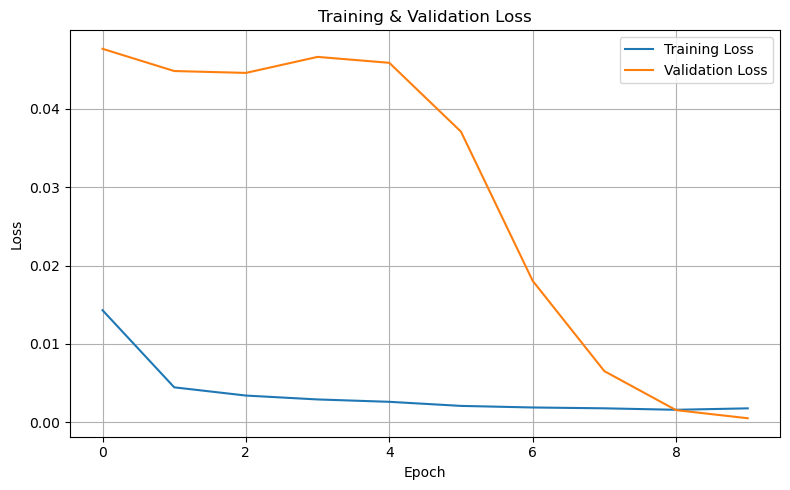

In [130]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X) 
        loss = criterion(preds, batch_Y) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            preds = model(val_X)
            loss = criterion(preds, val_Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluation

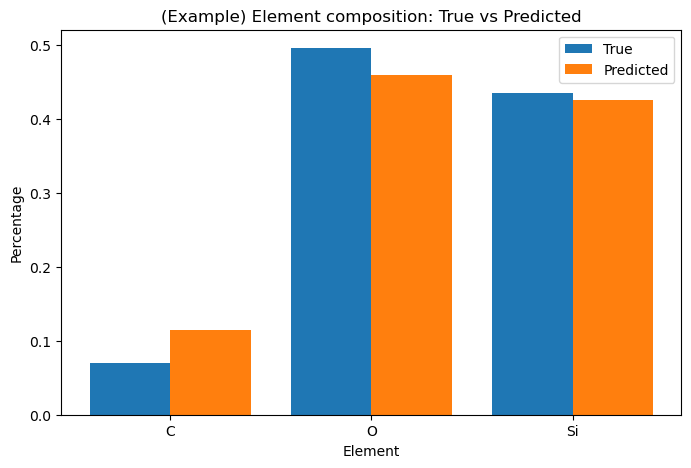

In [131]:
# Choose one random example from validation set
model.eval()

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)

        # take one sample
        preds = model(val_X)            # [B, num_elements]
        pred_probs = preds[15].cpu()
        true_probs = val_Y[15].cpu()

        # plot
        x = torch.arange(len(true_probs))
        element_names = element_list

        plt.figure(figsize=(8, 5))
        plt.bar(x - 0.2, true_probs, width=0.4, label='True')
        plt.bar(x + 0.2, pred_probs, width=0.4, label='Predicted')
        plt.xlabel("Element")
        plt.ylabel("Percentage")
        plt.title("(Example) Element composition: True vs Predicted")
        plt.xticks(x, element_names)
        plt.legend()
        plt.show()
        break  # just show one sample

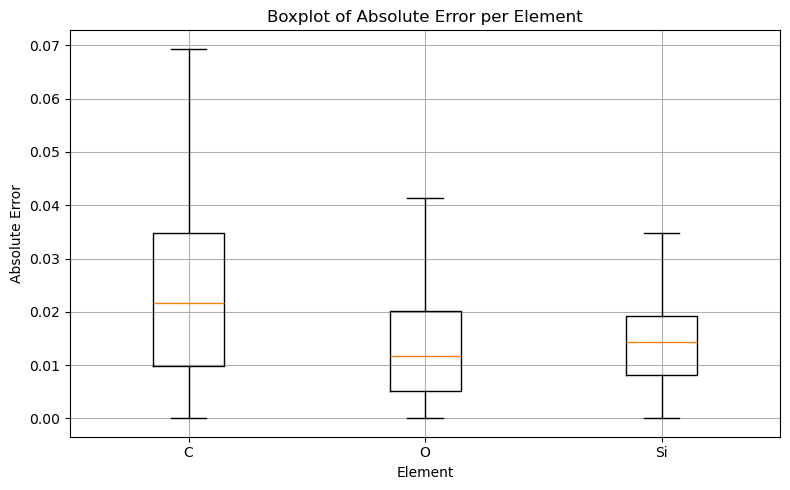

In [132]:
# Boxplot of abs error
model.eval()

abs_errors = []

all_true = []
all_pred = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)
        preds = model(val_X)
        preds = preds.cpu()
        val_Y = val_Y.cpu()

        all_true.append(val_Y)
        all_pred.append(preds)


true_all = torch.cat(all_true, dim=0)
pred_all = torch.cat(all_pred, dim=0)

abs_errors = torch.abs(pred_all - true_all).numpy()  # shape: [N, num_elements]

# boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(abs_errors, tick_labels=element_list, showfliers=False)
plt.ylabel("Absolute Error")
plt.xlabel("Element")
plt.title("Boxplot of Absolute Error per Element")
plt.grid(True)
plt.tight_layout()
plt.show()


### Question

- Loss function

- Any more evaluation method or plot to do in next step?

### Next Step

- Check dataset distribution by Carbon fraction

- Try different loss function: RMSE, 

- Evaluation point: uncertainty

- Try different DL models


## Distribution and Error Analysis by Carbon Fraction

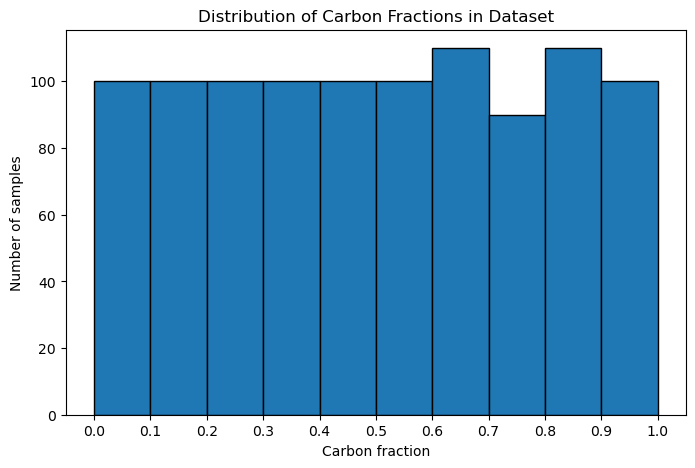

In [133]:
carbon_fractions = Y[:, 0].numpy()

bins = [i/10 for i in range(11)]''

plt.figure(figsize=(8, 5))
plt.hist(carbon_fractions, bins=bins, edgecolor='black')
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Dataset")
plt.xticks(bins)
plt.show()

In [134]:
print(pred_all.shape)

torch.Size([202, 3])


(202,)


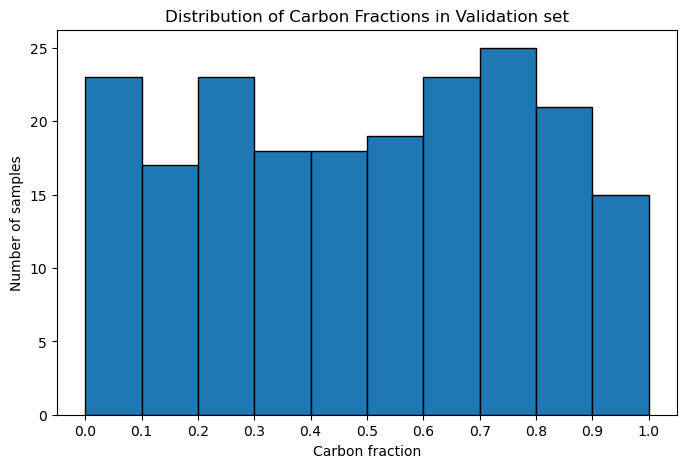

In [135]:
carbon_index = 0
true_c = true_all[:, carbon_index].numpy()
print(true_c.shape)

bins = [i/10 for i in range(11)]

plt.figure(figsize=(8, 5))
plt.hist(true_c, bins=bins, edgecolor='black')
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Validation set")
plt.xticks(bins)
plt.show()

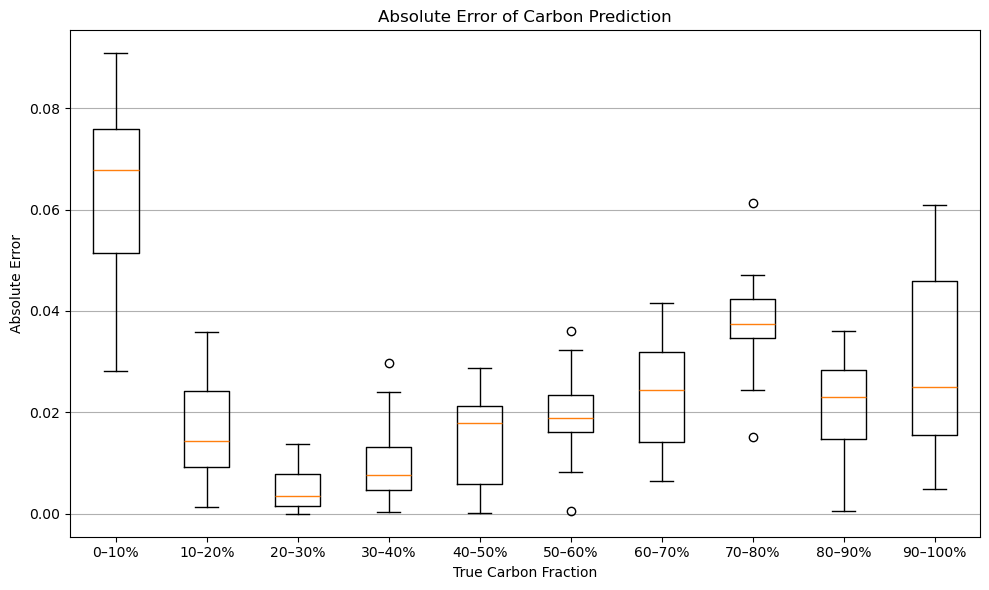

In [136]:
carbon_index = 0
true_c = true_all[:, carbon_index].numpy()
pred_c = pred_all[:, carbon_index].numpy()
abs_errors = np.abs(true_c - pred_c)

# bins：0-10%, 10-20%, ..., 90-100%
bins = np.linspace(0, 1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_c, bins) - 1  # bin index from 0 to 9

# Collect abs error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, abs_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of Carbon Prediction")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Uncertainty estimation

In [137]:
# MC dropout (failed)

def enable_dropout(model):
    """Force dropout layers to be active during evaluation."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

In [138]:
val_X = []
val_Y = []

for x, y in val_dataset:
    val_X.append(x)
    val_Y.append(y)

val_X = torch.stack(val_X)  # shape: [202, 1, 1440]
val_Y = torch.stack(val_Y)  # shape: [202, 3]


enable_dropout(model)
model.eval()

n_samples = 5
mc_preds = []


for _ in range(n_samples):
    preds = model(val_X.to(device))
    print(preds[0].detach().cpu().numpy())
    mc_preds.append(preds.detach().cpu().numpy())

mc_preds = np.stack(mc_preds)  # [50, 202, 3]
mean_preds = mc_preds.mean(axis=0)  # [202, 3]
std_preds = mc_preds.std(axis=0)    # [202, 3]


[0.92621267 0.03975567 0.03403164]
[0.92621267 0.03975567 0.03403164]
[0.92621267 0.03975567 0.03403164]
[0.92621267 0.03975567 0.03403164]
[0.92621267 0.03975567 0.03403164]


In [73]:
print(std_preds[:20,0])

[0.0000000e+00 5.9604645e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.4901161e-08 0.0000000e+00 0.0000000e+00 2.9802322e-08
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.9604645e-08]


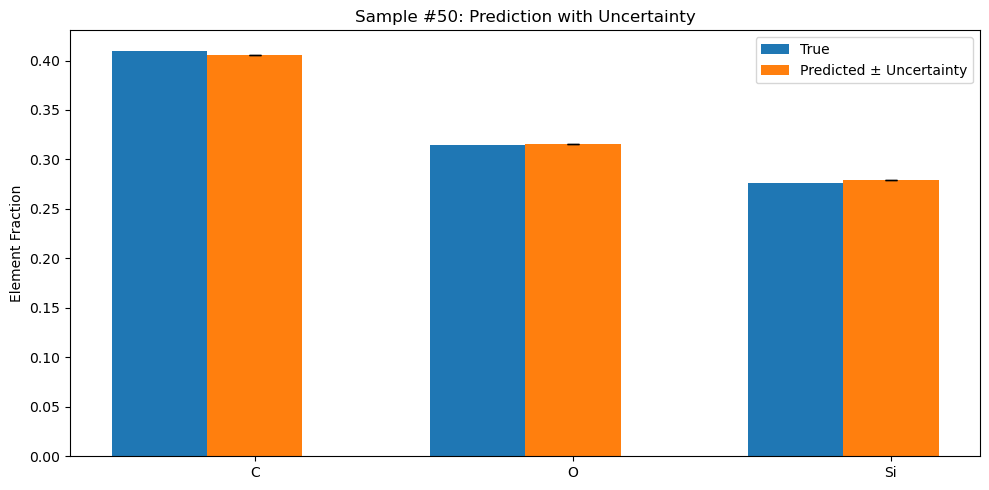

In [74]:
# Just show one
i = 50 

mean_i = mean_preds[i]
std_i = std_preds[i]
true_i = val_Y[i].detach().cpu().numpy() if torch.is_tensor(val_Y[i]) else val_Y[i]

x = np.arange(len(mean_i))
width = 0.3

plt.figure(figsize=(10, 5))
plt.bar(x - width, true_i, width=width, label="True", color="tab:blue")
plt.bar(x, mean_i, width=width, yerr=std_i, capsize=4, label="Predicted ± Uncertainty", color="tab:orange")
plt.xticks(x, element_list)
plt.ylabel("Element Fraction")
plt.title(f"Sample #{i}: Prediction with Uncertainty")
plt.legend()
plt.tight_layout()
plt.show()
